# Trabalho 1 - Nivelamento

Considere os datasets abaixo, estratégias de pré-processamento, medidas de avaliação, métodos de comparação estatística e os seguintes algoritmos de aprendizado de máquina: árvore de decisão, random forest e k-nearest neighbor. A partir disso, responda as seguintes perguntas:

1. Qual o algoritmo de AM mais adequado para cada problema?
2. Qual o algoritmo de AM mais adequado para todos os problemas?

Para responder essas questões construa um notebook no colab ou um ambiente similar. Documente de forma clara cada passo e justifique suas decisões.

### Datasets
Considere os seguintes datasets:

+ **Arrhythmia:** Binarized version of the original data set (see version 1). The multi-class target feature is converted to a two-class nominal target feature by re-labeling the majority class as positive ('P') and all others as negative ('N'). [link](https://www.openml.org/search?type=data&sort=runs&id=1017&status=active)

+ **Airlines:** Airlines Dataset Inspired in the regression dataset from Elena Ikonomovska. The task is to predict whether a given flight will be delayed, given the information of the scheduled departure. [link] (https://www.openml.org/search?type=data&sort=runs&id=1169&status=active)

+ **Phoneme:** The aim of this dataset is to distinguish between nasal (class 0) and oral sounds (class 1). Five different attributes were chosen to characterize each vowel: they are the amplitudes of the five first harmonics AHi, normalised by the total energy Ene (integrated on all the frequencies): AHi/Ene. The phonemes are transcribed as follows: sh as in she, dcl as in dark, iy as the vowel in she, aa as the vowel in dark, and ao as the first vowel in water. [link] (https://www.openml.org/search?type=data&sort=runs&id=1489&status=active)

+ **Phishing Websites:** One of the challenges faced by our research was the unavailability of reliable training datasets. In fact this challenge faces any researcher in the field. However, although plenty of articles about predicting phishing websites have been disseminated these days, no reliable training dataset has been published publically, may be because there is no agreement in literature on the definitive features that characterize phishing webpages, hence it is difficult to shape a dataset that covers all possible features. In this dataset, we shed light on the important features that have proved to be sound and effective in predicting phishing websites. [link](https://www.openml.org/search?type=data&sort=runs&id=4534&status=active)

+ **Satellite:** The satellite dataset comprises of features extracted from satellite observations. In particular, each image was taken under four different light wavelength, two in visible light (green and red) and two infrared images. The task of the original dataset is to classify the image into the soil category of the observed region. [link](https://www.openml.org/search?type=data&sort=runs&id=40900&status=active)

+ **Adult:** Prediction task is to determine whether a person makes over 50K a year. Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0)).[link](https://www.openml.org/search?type=data&sort=runs&id=1590&status=active)

+ **AedesSex:** This dataset has features of sounds gathered using a infrared sensor from _Ae. aegypti_ mosquitoes. The objetive is to classify males and females mosquitoes from their sounds. **Sex** feature is the label. [link](https://github.com/denismr/Classification-and-Counting-with-Recurrent-Contexts/blob/master/codeAndData/data/AedesSex.csv)



### Nome: Jedson Gabriel Ferreira de Paula

## Arrhythmia

### Dataset Loading and first look

In [ ]:
from scipy.io import arff
import pandas as pd

data = arff.loadarff('./datasets/arrhythmia.arff')
df_arrhythmia = pd.DataFrame(data[0])

df_arrhythmia.head()

In [ ]:
df_arrhythmia.describe()

### Skimming

In [ ]:
# !pip install skimpy
from skimpy import skim

skim(df_arrhythmia)


### Preprocessing

#### missing values

In [ ]:
# removing columns with any missing values
df_arrhythmia = df_arrhythmia.dropna(axis='columns')

df_arrhythmia.isna().sum().sort_values(ascending=False)

#### object columns

In [ ]:
arr_obj_cols = df_arrhythmia.columns[df_arrhythmia.dtypes == object]

df_arrhythmia[arr_obj_cols].head()

In [ ]:
arr_unary_cols = []

for col in arr_obj_cols:
    # if is a binary column
    if len(df_arrhythmia[col].unique()) == 2:
        bin_values = df_arrhythmia[col].unique()
        df_arrhythmia[col] = df_arrhythmia[col].map({bin_values[0]: 0, bin_values[1]: 1})
    # if column is unary
    elif len(df_arrhythmia[col].unique()) == 1:
        arr_unary_cols.append(col)
    # print problematic column
    else:
        print(col, len(df_arrhythmia[col].unique()))

# removing unary cols
df_arrhythmia = df_arrhythmia.drop(columns=arr_unary_cols)

arr_obj_cols = [col for col in arr_obj_cols.values if col not in arr_unary_cols]
df_arrhythmia[arr_obj_cols].head()


#### target class balancing

In [ ]:
df_arrhythmia['binaryClass'].value_counts().plot.bar()


In [ ]:
arr_bal = df_arrhythmia['binaryClass'].value_counts()[0] / df_arrhythmia['binaryClass'].count()
print(f"{arr_bal * 100:.2f}% {(1 - arr_bal) * 100:.2f}% of disbalancing")


#### Normalizing

In [ ]:
arr_X = df_arrhythmia.drop(columns=['binaryClass'])
arr_y = df_arrhythmia['binaryClass']

arr_X = (arr_X - arr_X.mean()) / arr_X.std()

arr_X = arr_X.dropna(axis='columns')

arr_X.head()


### Model Training

#### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

arr_dt_params_file = "./params/arr_decision_tree_grided_cv.json"
arr_dt_scores = []

if not exists(arr_dt_params_file):
    # instantiating classifier
    arr_decision_tree_clf = DecisionTreeClassifier(random_state=0)
    # defining testing params
    arr_tree_param = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150]
    }
    # training on each param combination
    arr_decision_tree_grided_cv = GridSearchCV(arr_decision_tree_clf, arr_tree_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    arr_decision_tree_grided_cv.fit(arr_X, arr_y)
    # write file with parameters to save on computation next run
    with open(arr_dt_params_file, "w+") as param_f:
        json.dump(arr_decision_tree_grided_cv.best_params_, param_f, indent=4)

        arr_dt_scores = cross_val_score(arr_decision_tree_grided_cv, arr_X, arr_y, cv=10)
        print(arr_dt_scores)
        plot_confusion_matrix(arr_decision_tree_grided_cv, arr_X, arr_y)
else:
    # read params file
    with open(arr_dt_params_file, "r") as param_f:
        # instantiating classifier
        arr_decision_tree_clf = DecisionTreeClassifier(random_state=0, **json.load(param_f))
        arr_decision_tree_grided_cv = arr_decision_tree_clf.fit(arr_X, arr_y)

        arr_dt_scores = cross_val_score(arr_decision_tree_grided_cv, arr_X, arr_y, cv=10)
        print(arr_dt_scores)
        plot_confusion_matrix(arr_decision_tree_grided_cv, arr_X, arr_y)


#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

arr_rf_params_file = "./params/arr_random_forest_grided_cv.json"
arr_rf_scores = []

if not exists(arr_rf_params_file):
    # instantiating classifier
    arr_random_forest_clf = RandomForestClassifier(random_state=0)
    # defining testing params
    arr_tree_param = {
        'bootstrap': [True, False],
        'max_depth': [10, 20, None], # 30, 40, 50, 60, 70, 80, 90, 100, 
        'max_features': ['sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600] #, 800, 1000, 1200, 1400, 1600, 1800, 2000
    }
    # training on each param combination
    arr_random_forest_grided_cv = GridSearchCV(arr_random_forest_clf, arr_tree_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    arr_random_forest_grided_cv.fit(arr_X, arr_y)

    with open("./params/arr_random_forest_grided_cv.json", "w") as param_f:
        json.dump(arr_random_forest_grided_cv.best_params_, param_f, indent=4)

        arr_rf_scores = cross_val_score(arr_random_forest_grided_cv, arr_X, arr_y, cv=10)
        print(arr_rf_scores)
        plot_confusion_matrix(arr_random_forest_grided_cv, arr_X, arr_y)
else:
    with open(arr_rf_params_file, "r") as param_f:
        # instantiating classifier
        arr_random_forest_clf = RandomForestClassifier(random_state=0, **json.load(param_f))
        arr_random_forest_grided_cv = arr_random_forest_clf.fit(arr_X, arr_y)

        arr_rf_scores = cross_val_score(arr_random_forest_grided_cv, arr_X, arr_y, cv=10)
        print(arr_rf_scores)
        plot_confusion_matrix(arr_random_forest_grided_cv, arr_X, arr_y)


#### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

arr_knn_params_file = "./params/arr_knn_grided_cv.json"
arr_knn_scores = []

if not exists(arr_knn_params_file):
    # instantiating classifier
    arr_knn_clf = KNeighborsClassifier()
    # defining testing params
    arr_knn_param = dict(n_neighbors=list(range(1, 31)))
    # training on each param combination
    arr_knn_grided_cv = GridSearchCV(arr_knn_clf, arr_knn_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    arr_knn_grided_cv.fit(arr_X, arr_y)

    with open("./params/arr_knn_grided_cv.json", "w") as param_f:
        json.dump(arr_knn_grided_cv.best_params_, param_f, indent=4)

        arr_knn_scores = cross_val_score(arr_knn_grided_cv, arr_X, arr_y, cv=10)
        print(arr_knn_scores)
        plot_confusion_matrix(arr_knn_grided_cv, arr_X, arr_y)
else:
    with open(arr_knn_params_file, "r") as param_f:
        # instantiating classifier
        arr_knn_clf = KNeighborsClassifier(**json.load(param_f))
        arr_knn_grided_cv = arr_knn_clf.fit(arr_X, arr_y)

        arr_knn_scores = cross_val_score(arr_knn_grided_cv, arr_X, arr_y, cv=10)
        print(arr_knn_scores)
        plot_confusion_matrix(arr_knn_grided_cv, arr_X, arr_y)


### Model Evaluation

In [ ]:
# len(df_arrhythmia['chV6_DD_RPwaveExists'].unique())


## Airlines

### Dataset Loading and fist look

In [ ]:
from scipy.io import arff
import pandas as pd

data = arff.loadarff('./datasets/airlines.arff')
df_airlines = pd.DataFrame(data[0])

df_airlines.head()

In [ ]:
df_airlines.describe()


### Skimming

In [ ]:
# !pip install skimpy
from skimpy import skim

skim(df_airlines)


### Preprocessing

#### object columns

In [ ]:
air_obj_cols = list(df_airlines.columns[df_airlines.dtypes == object])

df_airlines[air_obj_cols].head()


In [ ]:
# special case for target column
air_obj_cols.remove('Delay')

df_airlines['Delay'] = df_airlines['Delay'].map({b'0': 0, b'1': 1})

df_airlines.head()


In [ ]:
# printing uniques for each object column
for col in air_obj_cols:
    print(f"{col} has {len(df_airlines[col].unique())} uniques")

In [ ]:

m_df_airlines = pd.get_dummies(df_airlines[air_obj_cols])
df_airlines = pd.concat([df_airlines, m_df_airlines], axis=1)
df_airlines = df_airlines.drop(columns=air_obj_cols)
df_airlines.head()


#### Target class balancing

In [ ]:
df_airlines['Delay'].value_counts().plot.bar()


In [ ]:
air_bal = df_airlines['Delay'].value_counts()[0] / df_airlines['Delay'].count()
print(f"{air_bal * 100:.2f}% {(1 - air_bal) * 100:.2f}% of disbalancing")


#### Normalizing

In [ ]:
air_X = df_airlines.drop(columns=['Delay'])
air_y = df_airlines['Delay']

air_X = (air_X - air_X.mean()) / air_X.std()

air_X = air_X.dropna(axis='columns')

air_X.head()


### Model Training

#### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

air_dt_params_file = "./params/air_decision_tree_grided_cv.json"
air_dt_scores = []

if not exists(air_dt_params_file):
    # instantiating classifier
    air_decision_tree_clf = DecisionTreeClassifier(random_state=0)
    # defining testing params
    air_tree_param = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150]
    }
    # training on each param combination
    air_decision_tree_grided_cv = GridSearchCV(air_decision_tree_clf, air_tree_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    air_decision_tree_grided_cv.fit(air_X, air_y)
    # write file with parameters to save on computation next run
    with open(air_dt_params_file, "w+") as param_f:
        json.dump(air_decision_tree_grided_cv.best_params_, param_f, indent=4)

        air_dt_scores = cross_val_score(air_decision_tree_grided_cv, air_X, air_y, cv=10)
        print(air_dt_scores)
        plot_confusion_matrix(air_decision_tree_grided_cv, air_X, air_y)
else:
    # read params file
    with open(air_dt_params_file, "r") as param_f:
        # instantiating classifier
        air_decision_tree_clf = DecisionTreeClassifier(random_state=0, **json.load(param_f))
        air_decision_tree_grided_cv = air_decision_tree_clf.fit(air_X, air_y)

        air_dt_scores = cross_val_score(air_decision_tree_grided_cv, air_X, air_y, cv=10)
        print(air_dt_scores)
        plot_confusion_matrix(air_decision_tree_grided_cv, air_X, air_y)


#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

air_rf_params_file = "./params/air_random_forest_grided_cv.json"
air_rf_scores = []

if not exists(air_rf_params_file):
    # instantiating classifier
    air_random_forest_clf = RandomForestClassifier(random_state=0)
    # defining testing params
    air_tree_param = {
        'bootstrap': [True, False],
        'max_depth': [10, 20, None], # 30, 40, 50, 60, 70, 80, 90, 100, 
        'max_features': ['sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600] #, 800, 1000, 1200, 1400, 1600, 1800, 2000
    }
    # training on each param combination
    air_random_forest_grided_cv = GridSearchCV(air_random_forest_clf, air_tree_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    air_random_forest_grided_cv.fit(air_X, air_y)

    with open("./params/air_random_forest_grided_cv.json", "w") as param_f:
        json.dump(air_random_forest_grided_cv.best_params_, param_f, indent=4)

        air_rf_scores = cross_val_score(air_random_forest_grided_cv, air_X, air_y, cv=10)
        print(air_rf_scores)
        plot_confusion_matrix(air_random_forest_grided_cv, air_X, air_y)
else:
    with open(air_rf_params_file, "r") as param_f:
        # instantiating classifier
        air_random_forest_clf = RandomForestClassifier(random_state=0, **json.load(param_f))
        air_random_forest_grided_cv = air_random_forest_clf.fit(air_X, air_y)

        air_rf_scores = cross_val_score(air_random_forest_grided_cv, air_X, air_y, cv=10)
        print(air_rf_scores)
        plot_confusion_matrix(air_random_forest_grided_cv, air_X, air_y)


#### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

air_knn_params_file = "./params/air_knn_grided_cv.json"
air_knn_scores = []

if not exists(air_knn_params_file):
    # instantiating classifier
    air_knn_clf = KNeighborsClassifier()
    # defining testing params
    air_knn_param = dict(n_neighbors=list(range(1, 31)))
    # training on each param combination
    air_knn_grided_cv = GridSearchCV(air_knn_clf, air_knn_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    air_knn_grided_cv.fit(air_X, air_y)

    with open("./params/air_knn_grided_cv.json", "w") as param_f:
        json.dump(air_knn_grided_cv.best_params_, param_f, indent=4)

        air_knn_scores = cross_val_score(air_knn_grided_cv, air_X, air_y, cv=10)
        print(air_knn_scores)
        plot_confusion_matrix(air_knn_grided_cv, air_X, air_y)
else:
    with open(air_knn_params_file, "r") as param_f:
        # instantiating classifier
        air_knn_clf = KNeighborsClassifier(**json.load(param_f))
        air_knn_grided_cv = air_knn_clf.fit(air_X, air_y)

        air_knn_scores = cross_val_score(air_knn_grided_cv, air_X, air_y, cv=10)
        print(air_knn_scores)
        plot_confusion_matrix(air_knn_grided_cv, air_X, air_y)


### Model Evaluation

## Phoneme

### Model Loading and first look

In [ ]:
from scipy.io import arff
import pandas as pd

data = arff.loadarff('./datasets/phonemes.arff')
df_phonemes = pd.DataFrame(data[0])

df_phonemes.head()


In [ ]:
df_phonemes.describe()


### Skimming

In [ ]:
# !pip install skimpy
from skimpy import skim

skim(df_phonemes)


### Preprocessing

#### object columns

In [ ]:
pho_obj_cols = list(df_phonemes.columns[df_phonemes.dtypes == object])

df_phonemes[pho_obj_cols].head()


In [ ]:
df_phonemes['Class'].unique()


In [ ]:
# special case for target column
pho_obj_cols.remove('Class')

df_phonemes['Class'] = df_phonemes['Class'].map({b'1': 0, b'2': 1})

df_phonemes.head()


#### Target class balancing

In [ ]:
df_phonemes['Class'].value_counts().plot.bar()


In [ ]:
pho_bal = df_phonemes['Class'].value_counts()[0] / df_phonemes['Class'].count()
print(f"{pho_bal * 100:.2f}% {(1 - pho_bal) * 100:.2f}% of disbalancing")


In [ ]:
# !pip install imblearn
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)

df_phonemes_target = df_phonemes['Class']
df_phonemes = df_phonemes.drop(columns=['Class'])
df_phonemes, df_phonemes_target = ros.fit_resample(df_phonemes, df_phonemes_target)

df_phonemes = pd.concat([df_phonemes, df_phonemes_target], axis=1)

pho_bal = df_phonemes['Class'].value_counts()[0] / df_phonemes['Class'].count()
print(f"{pho_bal * 100:.2f}% {(1 - pho_bal) * 100:.2f}% of disbalancing")


#### Normalizing

In [ ]:
pho_X = df_phonemes.drop(columns=['Class'])
pho_y = df_phonemes['Class']

pho_X = (pho_X - pho_X.mean()) / pho_X.std()

pho_X = pho_X.dropna(axis='columns')

pho_X.head()


### Model Training

#### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

pho_dt_params_file = "./params/pho_decision_tree_grided_cv.json"
pho_dt_scores = []

if not exists(pho_dt_params_file):
    # instantiating classifier
    pho_decision_tree_clf = DecisionTreeClassifier(random_state=0)
    # defining testing params
    pho_tree_param = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150]
    }
    # training on each param combination
    pho_decision_tree_grided_cv = GridSearchCV(pho_decision_tree_clf, pho_tree_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    pho_decision_tree_grided_cv.fit(pho_X, pho_y)
    # write file with parameters to save on computation next run
    with open(pho_dt_params_file, "w+") as param_f:
        json.dump(pho_decision_tree_grided_cv.best_params_, param_f, indent=4)

        pho_dt_scores = cross_val_score(pho_decision_tree_grided_cv, pho_X, pho_y, cv=10)
        print(pho_dt_scores)
        plot_confusion_matrix(pho_decision_tree_grided_cv, pho_X, pho_y)
else:
    # read params file
    with open(pho_dt_params_file, "r") as param_f:
        # instantiating classifier
        pho_decision_tree_clf = DecisionTreeClassifier(random_state=0, **json.load(param_f))
        pho_decision_tree_grided_cv = pho_decision_tree_clf.fit(pho_X, pho_y)

        pho_dt_scores = cross_val_score(pho_decision_tree_grided_cv, pho_X, pho_y, cv=10)
        print(pho_dt_scores)
        plot_confusion_matrix(pho_decision_tree_grided_cv, pho_X, pho_y)


#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

pho_rf_params_file = "./params/pho_random_forest_grided_cv.json"
pho_rf_scores = []

if not exists(pho_rf_params_file):
    # instantiating classifier
    pho_random_forest_clf = RandomForestClassifier(random_state=0)
    # defining testing params
    pho_tree_param = {
        'bootstrap': [True, False],
        'max_depth': [10, 20, None], # 30, 40, 50, 60, 70, 80, 90, 100, 
        'max_features': ['sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600] #, 800, 1000, 1200, 1400, 1600, 1800, 2000
    }
    # training on each param combination
    pho_random_forest_grided_cv = GridSearchCV(pho_random_forest_clf, pho_tree_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    pho_random_forest_grided_cv.fit(pho_X, pho_y)

    with open("./params/pho_random_forest_grided_cv.json", "w") as param_f:
        json.dump(pho_random_forest_grided_cv.best_params_, param_f, indent=4)

        pho_rf_scores = cross_val_score(pho_random_forest_grided_cv, pho_X, pho_y, cv=10)
        print(pho_rf_scores)
        plot_confusion_matrix(pho_random_forest_grided_cv, pho_X, pho_y)
else:
    with open(pho_rf_params_file, "r") as param_f:
        # instantiating classifier
        pho_random_forest_clf = RandomForestClassifier(random_state=0, **json.load(param_f))
        pho_random_forest_grided_cv = pho_random_forest_clf.fit(pho_X, pho_y)

        pho_rf_scores = cross_val_score(pho_random_forest_grided_cv, pho_X, pho_y, cv=10)
        print(pho_rf_scores)
        plot_confusion_matrix(pho_random_forest_grided_cv, pho_X, pho_y)


#### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

pho_knn_params_file = "./params/pho_knn_grided_cv.json"
pho_knn_scores = []

if not exists(pho_knn_params_file):
    # instantiating classifier
    pho_knn_clf = KNeighborsClassifier()
    # defining testing params
    pho_knn_param = dict(n_neighbors=list(range(1, 31)))
    # training on each param combination
    pho_knn_grided_cv = GridSearchCV(pho_knn_clf, pho_knn_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    pho_knn_grided_cv.fit(pho_X, pho_y)

    with open("./params/pho_knn_grided_cv.json", "w") as param_f:
        json.dump(pho_knn_grided_cv.best_params_, param_f, indent=4)

        pho_knn_scores = cross_val_score(pho_knn_grided_cv, pho_X, pho_y, cv=10)
        print(pho_knn_scores)
        plot_confusion_matrix(pho_knn_grided_cv, pho_X, pho_y)
else:
    with open(pho_knn_params_file, "r") as param_f:
        # instantiating classifier
        pho_knn_clf = KNeighborsClassifier(**json.load(param_f))
        pho_knn_grided_cv = pho_knn_clf.fit(pho_X, pho_y)

        pho_knn_scores = cross_val_score(pho_knn_grided_cv, pho_X, pho_y, cv=10)
        print(pho_knn_scores)
        plot_confusion_matrix(pho_knn_grided_cv, pho_X, pho_y)


### Model Evaluation

## Phishing Websites

### Model loading and first look

In [ ]:
from scipy.io import arff
import pandas as pd

data = arff.loadarff('./datasets/phishing.arff')
df_phishing = pd.DataFrame(data[0])

df_phishing.head()


In [ ]:
df_phishing.describe()


### Preprocessing

#### object columns

In [ ]:
phi_obj_cols = list(df_phishing.columns[df_phishing.dtypes == object])

df_phishing[phi_obj_cols].head()


In [ ]:
phi_unary_cols = []

for col in phi_obj_cols:
    curr_col_uniques = len(df_phishing[col].unique())
    # if is a binary column
    if curr_col_uniques == 2 or curr_col_uniques == 3:
        bin_values = df_phishing[col].unique()
        df_phishing[col] = df_phishing[col].map(lambda v: int(v))
    # if column is unary
    elif len(df_phishing[col].unique()) == 1:
        phi_unary_cols.append(col)
    # print problematic column
    else:
        print(col, len(df_phishing[col].unique()))

# removing unary cols
df_phishing = df_phishing.drop(columns=phi_unary_cols)

phi_obj_cols = [col for col in phi_obj_cols if col not in phi_unary_cols]
df_phishing[phi_obj_cols].head()


#### Target class balancing

In [ ]:
df_phishing['Result'].value_counts().plot.bar()


In [ ]:
phi_bal = df_phishing['Result'].value_counts()[1] / df_phishing['Result'].count()
print(f"{phi_bal * 100:.2f}% {(1 - phi_bal) * 100:.2f}% of disbalancing")


#### Normalizing

In [ ]:
phi_X = df_phishing.drop(columns=['Result'])
phi_y = df_phishing['Result']

phi_X = (phi_X - phi_X.mean()) / phi_X.std()

phi_X = phi_X.dropna(axis='columns')

phi_X.head()


### Model Training

#### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

phi_dt_params_file = "./params/phi_decision_tree_grided_cv.json"
phi_dt_scores = []

if not exists(phi_dt_params_file):
    # instantiating classifier
    phi_decision_tree_clf = DecisionTreeClassifier(random_state=0)
    # defining testing params
    phi_tree_param = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150]
    }
    # training on each param combination
    phi_decision_tree_grided_cv = GridSearchCV(phi_decision_tree_clf, phi_tree_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    phi_decision_tree_grided_cv.fit(phi_X, phi_y)
    # write file with parameters to save on computation next run
    with open(phi_dt_params_file, "w+") as param_f:
        json.dump(phi_decision_tree_grided_cv.best_params_, param_f, indent=4)

        phi_dt_scores = cross_val_score(phi_decision_tree_grided_cv, phi_X, phi_y, cv=10)
        print(phi_dt_scores)
        plot_confusion_matrix(phi_decision_tree_grided_cv, phi_X, phi_y)
else:
    # read params file
    with open(phi_dt_params_file, "r") as param_f:
        # instantiating classifier
        phi_decision_tree_clf = DecisionTreeClassifier(random_state=0, **json.load(param_f))
        phi_decision_tree_grided_cv = phi_decision_tree_clf.fit(phi_X, phi_y)

        phi_dt_scores = cross_val_score(phi_decision_tree_grided_cv, phi_X, phi_y, cv=10)
        print(phi_dt_scores)
        plot_confusion_matrix(phi_decision_tree_grided_cv, phi_X, phi_y)


#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

phi_rf_params_file = "./params/phi_random_forest_grided_cv.json"
phi_rf_scores = []

if not exists(phi_rf_params_file):
    # instantiating classifier
    phi_random_forest_clf = RandomForestClassifier(random_state=0)
    # defining testing params
    phi_tree_param = {
        'bootstrap': [True, False],
        'max_depth': [10, 20, None], # 30, 40, 50, 60, 70, 80, 90, 100, 
        'max_features': ['sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600] #, 800, 1000, 1200, 1400, 1600, 1800, 2000
    }
    # training on each param combination
    phi_random_forest_grided_cv = GridSearchCV(phi_random_forest_clf, phi_tree_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    phi_random_forest_grided_cv.fit(phi_X, phi_y)

    with open("./params/phi_random_forest_grided_cv.json", "w") as param_f:
        json.dump(phi_random_forest_grided_cv.best_params_, param_f, indent=4)

        phi_rf_scores = cross_val_score(phi_random_forest_grided_cv, phi_X, phi_y, cv=10)
        print(phi_rf_scores)
        plot_confusion_matrix(phi_random_forest_grided_cv, phi_X, phi_y)
else:
    with open(phi_rf_params_file, "r") as param_f:
        # instantiating classifier
        phi_random_forest_clf = RandomForestClassifier(random_state=0, **json.load(param_f))
        phi_random_forest_grided_cv = phi_random_forest_clf.fit(phi_X, phi_y)

        phi_rf_scores = cross_val_score(phi_random_forest_grided_cv, phi_X, phi_y, cv=10)
        print(phi_rf_scores)
        plot_confusion_matrix(phi_random_forest_grided_cv, phi_X, phi_y)


#### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

phi_knn_params_file = "./params/phi_knn_grided_cv.json"
phi_knn_scores = []

if not exists(phi_knn_params_file):
    # instantiating classifier
    phi_knn_clf = KNeighborsClassifier()
    # defining testing params
    phi_knn_param = dict(n_neighbors=list(range(1, 31)))
    # training on each param combination
    phi_knn_grided_cv = GridSearchCV(phi_knn_clf, phi_knn_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    phi_knn_grided_cv.fit(phi_X, phi_y)

    with open("./params/phi_knn_grided_cv.json", "w") as param_f:
        json.dump(phi_knn_grided_cv.best_params_, param_f, indent=4)

        phi_knn_scores = cross_val_score(phi_knn_grided_cv, phi_X, phi_y, cv=10)
        print(phi_knn_scores)
        plot_confusion_matrix(phi_knn_grided_cv, phi_X, phi_y)
else:
    with open(phi_knn_params_file, "r") as param_f:
        # instantiating classifier
        phi_knn_clf = KNeighborsClassifier(**json.load(param_f))
        phi_knn_grided_cv = phi_knn_clf.fit(phi_X, phi_y)

        phi_knn_scores = cross_val_score(phi_knn_grided_cv, phi_X, phi_y, cv=10)
        print(phi_knn_scores)
        plot_confusion_matrix(phi_knn_grided_cv, phi_X, phi_y)


### Model Evaluation

## Satellite

### Model loading and first look

In [ ]:
from scipy.io import arff
import pandas as pd

data = arff.loadarff('./datasets/satellite.arff')
df_satellite = pd.DataFrame(data[0])

df_satellite.head()


In [ ]:
df_satellite.describe()

### Skimming

In [ ]:
# !pip install skimpy
from skimpy import skim

skim(df_satellite)


### Preprocessing

#### object columns

In [ ]:
sat_obj_cols = list(df_satellite.columns[df_satellite.dtypes == object])

df_satellite[sat_obj_cols].head()


In [ ]:
df_satellite['Target'].unique()


In [ ]:
# special case for target column
sat_obj_cols.remove('Target')

df_satellite['Target'] = df_satellite['Target'].map({b'Anomaly': 0, b'Normal': 1})

df_satellite.head()


#### Target class balancing

In [ ]:
df_satellite['Target'].value_counts().plot.bar()


In [ ]:
sat_bal = df_satellite['Target'].value_counts()[1] / df_satellite['Target'].count()
print(f"{sat_bal * 100:.2f}% {(1 - sat_bal) * 100:.2f}% of disbalancing")


In [ ]:
# !pip install imblearn
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

smote_tmk = SMOTETomek(sampling_strategy=0.1)
ros = RandomUnderSampler(random_state=0)

df_satellite_target = df_satellite['Target']
df_satellite = df_satellite.drop(columns=['Target'])
df_satellite, df_satellite_target = smote_tmk.fit_resample(df_satellite, df_satellite_target)
df_satellite, df_satellite_target = ros.fit_resample(df_satellite, df_satellite_target)

df_satellite = pd.concat([df_satellite, df_satellite_target], axis=1)

sat_bal = df_satellite['Target'].value_counts()[0] / df_satellite['Target'].count()
print(f"counts:\n{df_satellite['Target'].value_counts()}")
print(f"{sat_bal * 100:.2f}% {(1 - sat_bal) * 100:.2f}% of disbalancing")


#### Normalizing

In [ ]:
sat_X = df_satellite.drop(columns=['Target'])
sat_y = df_satellite['Target']

sat_X = (sat_X - sat_X.mean()) / sat_X.std()

sat_X = sat_X.dropna(axis='columns')

sat_X.head()


### Model Training

#### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

sat_dt_params_file = "./params/sat_decision_tree_grided_cv.json"
sat_dt_scores = []

if not exists(sat_dt_params_file):
    # instantiating classifier
    sat_decision_tree_clf = DecisionTreeClassifier(random_state=0)
    # defining testing params
    sat_tree_param = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150]
    }
    # training on each param combination
    sat_decision_tree_grided_cv = GridSearchCV(sat_decision_tree_clf, sat_tree_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    sat_decision_tree_grided_cv.fit(sat_X, sat_y)
    # write file with parameters to save on computation next run
    with open(sat_dt_params_file, "w+") as param_f:
        json.dump(sat_decision_tree_grided_cv.best_params_, param_f, indent=4)

        sat_dt_scores = cross_val_score(sat_decision_tree_grided_cv, sat_X, sat_y, cv=10)
        print(sat_dt_scores)
        plot_confusion_matrix(sat_decision_tree_grided_cv, sat_X, sat_y)
else:
    # read params file
    with open(sat_dt_params_file, "r") as param_f:
        # instantiating classifier
        sat_decision_tree_clf = DecisionTreeClassifier(random_state=0, **json.load(param_f))
        sat_decision_tree_grided_cv = sat_decision_tree_clf.fit(sat_X, sat_y)

        sat_dt_scores = cross_val_score(sat_decision_tree_grided_cv, sat_X, sat_y, cv=10)
        print(sat_dt_scores)
        plot_confusion_matrix(sat_decision_tree_grided_cv, sat_X, sat_y)


#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

sat_rf_params_file = "./params/sat_random_forest_grided_cv.json"
sat_rf_scores = []

if not exists(sat_rf_params_file):
    # instantiating classifier
    sat_random_forest_clf = RandomForestClassifier(random_state=0)
    # defining testing params
    sat_tree_param = {
        'bootstrap': [True, False],
        'max_depth': [10, 20, None], # 30, 40, 50, 60, 70, 80, 90, 100, 
        'max_features': ['sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600] #, 800, 1000, 1200, 1400, 1600, 1800, 2000
    }
    # training on each param combination
    sat_random_forest_grided_cv = GridSearchCV(sat_random_forest_clf, sat_tree_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    sat_random_forest_grided_cv.fit(sat_X, sat_y)

    with open("./params/sat_random_forest_grided_cv.json", "w") as param_f:
        json.dump(sat_random_forest_grided_cv.best_params_, param_f, indent=4)

        sat_rf_scores = cross_val_score(sat_random_forest_grided_cv, sat_X, sat_y, cv=10)
        print(sat_rf_scores)
        plot_confusion_matrix(sat_random_forest_grided_cv, sat_X, sat_y)
else:
    with open(sat_rf_params_file, "r") as param_f:
        # instantiating classifier
        sat_random_forest_clf = RandomForestClassifier(random_state=0, **json.load(param_f))
        sat_random_forest_grided_cv = sat_random_forest_clf.fit(sat_X, sat_y)

        sat_rf_scores = cross_val_score(sat_random_forest_grided_cv, sat_X, sat_y, cv=10)
        print(sat_rf_scores)
        plot_confusion_matrix(sat_random_forest_grided_cv, sat_X, sat_y)


#### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

sat_knn_params_file = "./params/sat_knn_grided_cv.json"
sat_knn_scores = []

if not exists(sat_knn_params_file):
    # instantiating classifier
    sat_knn_clf = KNeighborsClassifier()
    # defining testing params
    sat_knn_param = dict(n_neighbors=list(range(1, 31)))
    # training on each param combination
    sat_knn_grided_cv = GridSearchCV(sat_knn_clf, sat_knn_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    sat_knn_grided_cv.fit(sat_X, sat_y)

    with open("./params/sat_knn_grided_cv.json", "w") as param_f:
        json.dump(sat_knn_grided_cv.best_params_, param_f, indent=4)

        sat_knn_scores = cross_val_score(sat_knn_grided_cv, sat_X, sat_y, cv=10)
        print(sat_knn_scores)
        plot_confusion_matrix(sat_knn_grided_cv, sat_X, sat_y)
else:
    with open(sat_knn_params_file, "r") as param_f:
        # instantiating classifier
        sat_knn_clf = KNeighborsClassifier(**json.load(param_f))
        sat_knn_grided_cv = sat_knn_clf.fit(sat_X, sat_y)

        sat_knn_scores = cross_val_score(sat_knn_grided_cv, sat_X, sat_y, cv=10)
        print(sat_knn_scores)
        plot_confusion_matrix(sat_knn_grided_cv, sat_X, sat_y)


### Model Evaluation

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare

stat, p = friedmanchisquare(sat_dt_scores, sat_rf_scores, sat_knn_scores) 

print("p = ", p)

if p < 0.01:
    print("Rejeitamos a hipótese nula")
else:
    print("Aceitamos a hipótese nula")

plt.boxplot([sat_dt_scores, sat_rf_scores, sat_knn_scores], labels=['Decision Tree', 'Random Forest', 'KNN'])
plt.ylim(0.8, 1)
plt.title("Satellite Models Evaluation Scores")
plt.show()


## Adult

### Data loading and first look

In [ ]:
from scipy.io import arff
import pandas as pd

data = arff.loadarff('./datasets/adult.arff')
df_adult = pd.DataFrame(data[0])

df_adult.head()


In [ ]:
df_adult.describe()

### Skimming

In [ ]:
# !pip install skimpy
from skimpy import skim

skim(df_adult)


### Preprocessing

#### object columns

In [ ]:
adu_obj_cols = list(df_adult.columns[df_adult.dtypes == object])

df_adult[adu_obj_cols].head()


In [ ]:
# printing uniques for each object column
for col in adu_obj_cols:
    print(f"{col} has {len(df_adult[col].unique())} uniques")
    

In [ ]:
adu_unary_cols = []

for col in adu_obj_cols:
    curr_col_uniques = len(df_adult[col].unique())
    # if is a binary column
    if curr_col_uniques == 2:
        bin_values = list(df_adult[col].unique())
        df_adult[col] = df_adult[col].map({bin_values[0]: 0, bin_values[1]: 1})
    # if column is unary
    elif len(df_adult[col].unique()) == 1:
        # add unary column to list
        adu_unary_cols.append(col)
    # print one hot encode column
    else:
        # get dummies of current column
        m_df_adult = pd.get_dummies(df_adult[col], prefix=col)
        # concat to original dataframe
        df_adult = pd.concat([df_adult, m_df_adult], axis=1)
        # drop current column from original dataframe
        df_adult = df_adult.drop(columns=[col])

# removing unary cols
df_adult = df_adult.drop(columns=adu_unary_cols)

adu_obj_cols = [col for col in adu_obj_cols if col not in adu_unary_cols]
df_adult.head()


#### Target class balancing

In [ ]:
adu_bal = df_adult['class'].value_counts()[1] / df_adult['class'].count()
print(f"{adu_bal * 100:.2f}% {(1 - adu_bal) * 100:.2f}% of disbalancing")

df_adult['class'].value_counts().plot.bar()


In [ ]:
# !pip install imblearn
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

smote_tmk = SMOTETomek(sampling_strategy=0.35)
ros = RandomUnderSampler(random_state=0)

df_adult_target = df_adult['class']
df_adult = df_adult.drop(columns=['class'])
# smote oversampling of minority class
df_adult, df_adult_target = smote_tmk.fit_resample(df_adult, df_adult_target)
# random downsampling of majority class
df_adult, df_adult_target = ros.fit_resample(df_adult, df_adult_target)

df_adult = pd.concat([df_adult, df_adult_target], axis=1)

adu_bal = df_adult['class'].value_counts()[0] / df_adult['class'].count()
print(f"counts:\n{df_adult['class'].value_counts()}")
print(f"{adu_bal * 100:.2f}% {(1 - adu_bal) * 100:.2f}% of disbalancing")
df_adult['class'].value_counts().plot.bar()


#### Normalizing

In [ ]:
adu_X = df_adult.drop(columns=['class'])
adu_y = df_adult['class']

adu_X = (adu_X - adu_X.mean()) / adu_X.std()

adu_X = adu_X.dropna(axis='columns')

adu_X.head()


### Model Training

#### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

adu_dt_params_file = "./params/adu_decision_tree_grided_cv.json"
adu_dt_scores = []

if not exists(adu_dt_params_file):
    # instantiating classifier
    adu_decision_tree_clf = DecisionTreeClassifier(random_state=0)
    # defining testing params
    adu_tree_param = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150]
    }
    # training on each param combination
    adu_decision_tree_grided_cv = GridSearchCV(adu_decision_tree_clf, adu_tree_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    adu_decision_tree_grided_cv.fit(adu_X, adu_y)
    # write file with parameters to save on computation next run
    with open(adu_dt_params_file, "w+") as param_f:
        json.dump(adu_decision_tree_grided_cv.best_params_, param_f, indent=4)

        adu_dt_scores = cross_val_score(adu_decision_tree_grided_cv, adu_X, adu_y, cv=10)
        print(adu_dt_scores)
        plot_confusion_matrix(adu_decision_tree_grided_cv, adu_X, adu_y)
else:
    # read params file
    with open(adu_dt_params_file, "r") as param_f:
        # instantiating classifier
        adu_decision_tree_clf = DecisionTreeClassifier(random_state=0, **json.load(param_f))
        adu_decision_tree_grided_cv = adu_decision_tree_clf.fit(adu_X, adu_y)

        adu_dt_scores = cross_val_score(adu_decision_tree_grided_cv, adu_X, adu_y, cv=10)
        print(adu_dt_scores)
        plot_confusion_matrix(adu_decision_tree_grided_cv, adu_X, adu_y)


#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

adu_rf_params_file = "./params/adu_random_forest_grided_cv.json"
adu_rf_scores = []

if not exists(adu_rf_params_file):
    # instantiating classifier
    adu_random_forest_clf = RandomForestClassifier(random_state=0)
    # defining testing params
    adu_tree_param = {
        'bootstrap': [True, False],
        'max_depth': [10, 20, None], # 30, 40, 50, 60, 70, 80, 90, 100, 
        'max_features': ['sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600] #, 800, 1000, 1200, 1400, 1600, 1800, 2000
    }
    # training on each param combination
    adu_random_forest_grided_cv = GridSearchCV(adu_random_forest_clf, adu_tree_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    adu_random_forest_grided_cv.fit(adu_X, adu_y)

    with open("./params/adu_random_forest_grided_cv.json", "w") as param_f:
        json.dump(adu_random_forest_grided_cv.best_params_, param_f, indent=4)

        adu_rf_scores = cross_val_score(adu_random_forest_grided_cv, adu_X, adu_y, cv=10)
        print(adu_rf_scores)
        plot_confusion_matrix(adu_random_forest_grided_cv, adu_X, adu_y)
else:
    with open(adu_rf_params_file, "r") as param_f:
        # instantiating classifier
        adu_random_forest_clf = RandomForestClassifier(random_state=0, **json.load(param_f))
        adu_random_forest_grided_cv = adu_random_forest_clf.fit(adu_X, adu_y)

        adu_rf_scores = cross_val_score(adu_random_forest_grided_cv, adu_X, adu_y, cv=10)
        print(adu_rf_scores)
        plot_confusion_matrix(adu_random_forest_grided_cv, adu_X, adu_y)


#### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

adu_knn_params_file = "./params/adu_knn_grided_cv.json"
adu_knn_scores = []

if not exists(adu_knn_params_file):
    # instantiating classifier
    adu_knn_clf = KNeighborsClassifier()
    # defining testing params
    adu_knn_param = dict(n_neighbors=list(range(1, 31)))
    # training on each param combination
    adu_knn_grided_cv = GridSearchCV(adu_knn_clf, adu_knn_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    adu_knn_grided_cv.fit(adu_X, adu_y)

    with open("./params/adu_knn_grided_cv.json", "w") as param_f:
        json.dump(adu_knn_grided_cv.best_params_, param_f, indent=4)

        adu_knn_scores = cross_val_score(adu_knn_grided_cv, adu_X, adu_y, cv=10)
        print(adu_knn_scores)
        plot_confusion_matrix(adu_knn_grided_cv, adu_X, adu_y)
else:
    with open(adu_knn_params_file, "r") as param_f:
        # instantiating classifier
        adu_knn_clf = KNeighborsClassifier(**json.load(param_f))
        adu_knn_grided_cv = adu_knn_clf.fit(adu_X, adu_y)

        adu_knn_scores = cross_val_score(adu_knn_grided_cv, adu_X, adu_y, cv=10)
        print(adu_knn_scores)
        plot_confusion_matrix(adu_knn_grided_cv, adu_X, adu_y)


### Model Evaluation

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare

stat, p = friedmanchisquare(adu_dt_scores, adu_rf_scores, adu_knn_scores) 

print("p = ", p)

if p < 0.01:
    print("Rejeitamos a hipótese nula")
else:
    print("Aceitamos a hipótese nula")

plt.boxplot([adu_dt_scores, adu_rf_scores, adu_knn_scores], labels=['Decision Tree', 'Random Forest', 'KNN'])
plt.ylim(0.8, 1)
plt.title("Adult Models Evaluation Scores")
plt.show()


## AedesSex

### Data loading and first look

In [8]:
import pandas as pd

df_aedes = pd.read_csv('./datasets/aedessex.csv')

df_aedes.head()


,wbf,eh_1,eh_2,eh_3,eh_4,eh_5,eh_6,eh_7,eh_8,eh_9,...,eh_18,eh_19,eh_20,eh_21,eh_22,eh_23,eh_24,eh_25,sex,temp_range
0,474.193548,0.178585,0.172441,0.043769,0.265499,0.068176,0.128343,0.028126,0.037949,0.419316,...,0.017487,0.054026,0.256456,0.284075,0.109668,0.027885,0.019769,0.017994,F,1
1,495.505618,0.382748,0.383926,0.053126,0.656619,0.175272,0.308242,0.159714,0.030291,0.110074,...,0.054666,0.025495,0.026829,0.159360,0.409562,0.273947,0.074906,0.027396,F,1
2,501.136364,1.110597,1.039894,0.172886,1.392900,0.608041,0.410281,0.208344,0.051975,0.174283,...,0.076497,0.034553,0.033132,0.128890,0.479620,0.453797,0.151702,0.040911,F,1
3,506.896552,0.218450,0.218481,0.027408,0.432591,0.176818,0.229486,0.091719,0.009900,0.026317,...,0.024036,0.014079,0.009909,0.036424,0.296862,0.341512,0.125294,0.018248,F,1
4,565.384615,0.034858,0.058285,0.173607,0.036100,0.377893,0.048056,0.217498,0.074811,0.023332,...,0.072753,0.020873,0.028847,0.020273,0.022124,0.027397,0.116446,0.231712,F,1


In [2]:
df_aedes.describe()


,wbf,eh_1,eh_2,eh_3,eh_4,eh_5,eh_6,eh_7,eh_8,eh_9,...,eh_17,eh_18,eh_19,eh_20,eh_21,eh_22,eh_23,eh_24,eh_25,temp_range
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,...,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000
mean,698.061847,0.172435,0.239883,0.260350,0.257254,0.322712,0.247699,0.208674,0.195380,0.192886,...,0.130928,0.135651,0.140389,0.143489,0.147864,0.146633,0.138574,0.131573,0.127364,3.500000
std,177.899633,0.195594,0.245362,0.254382,0.278326,0.349547,0.259940,0.230480,0.227332,0.248351,...,0.195018,0.199675,0.206210,0.208755,0.217818,0.218793,0.204806,0.201142,0.195002,1.707861
min,108.088235,0.004229,0.004817,0.009122,0.007499,0.006478,0.004713,0.006262,0.006079,0.003202,...,0.005013,0.006455,0.005085,0.004034,0.005109,0.003830,0.004189,0.003833,0.005629,1.000000
25%,558.227848,0.050685,0.074270,0.092203,0.078841,0.090025,0.074773,0.053586,0.049789,0.047484,...,0.031867,0.032831,0.033787,0.033282,0.031467,0.030409,0.029776,0.027696,0.027788,2.000000
50%,648.529412,0.107268,0.164514,0.188395,0.168815,0.206103,0.166819,0.127101,0.117463,0.100174,...,0.060731,0.062206,0.063588,0.061975,0.058073,0.055071,0.052873,0.049390,0.047741,3.500000
75%,848.076923,0.221448,0.318468,0.338421,0.329974,0.424458,0.327554,0.280880,0.257165,0.236039,...,0.134489,0.144456,0.147395,0.153118,0.160280,0.160622,0.153307,0.139322,0.130279,5.000000
max,1225.000000,3.050939,3.384026,3.642700,5.018710,4.463279,3.793984,3.199406,4.161897,2.892276,...,3.401515,3.491121,2.866865,2.796163,2.689587,2.603801,3.380786,3.067694,2.904592,6.000000


### Skimming

In [3]:
# !pip install skimpy
from skimpy import skim

skim(df_aedes)


╭───────────────────────────────────── skimpy summary ──────────────────────────────────────╮
│          Data Summary                Data Types                                           │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                    │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                    │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                    │
│ │ Number of rows    │ 24000  │ │ float64     │ 26    │                                    │
│ │ Number of columns │ 28     │ │ object      │ 1     │                                    │
│ └───────────────────┴────────┘ │ int64       │ 1     │                                    │
│                                └─────────────┴───────┘                                    │
│                                          number                                           │
│ ┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━━┓  │
│ ┃          ┃ missing ┃ complete  ┃ mean ┃ sd   ┃ p0     ┃ p25   ┃ p75  ┃ p100 ┃ hist   ┃  │
│ ┃          ┃         ┃ rate      ┃      ┃      ┃        ┃       ┃      ┃      ┃        ┃  │
│ ┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━━━┩  │
│ │ wbf      │       0 │         1 │  700 │  180 │    110 │   560 │  850 │ 1200 │  ▁█▄▄  │  │
│ │ eh_1     │       0 │         1 │ 0.17 │  0.2 │ 0.0042 │ 0.051 │ 0.22 │  3.1 │   █    │  │
│ │ eh_2     │       0 │         1 │ 0.24 │ 0.25 │ 0.0048 │ 0.074 │ 0.32 │  3.4 │   █▁   │  │
│ │ eh_3     │       0 │         1 │ 0.26 │ 0.25 │ 0.0091 │ 0.092 │ 0.34 │  3.6 │   █▁   │  │
│ │ eh_4     │       0 │         1 │ 0.26 │ 0.28 │ 0.0075 │ 0.079 │ 0.33 │    5 │   █    │  │
│ │ eh_5     │       0 │         1 │ 0.32 │ 0.35 │ 0.0065 │  0.09 │ 0.42 │  4.5 │   █▁   │  │
│ │ eh_6     │       0 │         1 │ 0.25 │ 0.26 │ 0.0047 │ 0.075 │ 0.33 │  3.8 │   █▁   │  │
│ │ eh_7     │       0 │         1 │ 0.21 │ 0.23 │ 0.0063 │ 0.054 │ 0.28 │  3.2 │   █▁   │  │
│ │ eh_8     │       0 │         1 │  0.2 │ 0.23 │ 0.0061 │  0.05 │ 0.26 │  4.2 │   █    │  │
│ │ eh_9     │       0 │         1 │ 0.19 │ 0.25 │ 0.0032 │ 0.047 │ 0.24 │  2.9 │   █▁   │  │
│ │ eh_10    │       0 │         1 │ 0.24 │ 0.32 │ 0.0067 │ 0.047 │  0.3 │  5.7 │   █    │  │
│ │ eh_11    │       0 │         1 │ 0.27 │ 0.38 │ 0.0058 │ 0.051 │ 0.34 │    5 │   █▁   │  │
│ │ eh_12    │       0 │         1 │ 0.29 │ 0.39 │ 0.0063 │ 0.049 │ 0.38 │  4.5 │   █▁   │  │
│ │ eh_13    │       0 │         1 │ 0.25 │ 0.33 │ 0.0039 │ 0.048 │ 0.32 │  4.3 │   █▁   │  │
│ │ eh_14    │       0 │         1 │ 0.18 │ 0.25 │ 0.0043 │ 0.043 │ 0.22 │  3.8 │   █    │  │
│ │ eh_15    │       0 │         1 │ 0.14 │ 0.21 │ 0.0065 │ 0.037 │ 0.15 │  3.7 │   █    │  │
│ │ eh_16    │       0 │         1 │ 0.13 │ 0.19 │ 0.0066 │ 0.034 │ 0.13 │  3.6 │   █    │  │
│ │ eh_17    │       0 │         1 │ 0.13 │  0.2 │  0.005 │ 0.032 │ 0.13 │  3.4 │   █    │  │
│ │ eh_18    │       0 │         1 │ 0.14 │  0.2 │ 0.0065 │ 0.033 │ 0.14 │  3.5 │   █    │  │
│ │ eh_19    │       0 │         1 │ 0.14 │ 0.21 │ 0.0051 │ 0.034 │ 0.15 │  2.9 │   █    │  │
│ │ eh_20    │       0 │         1 │ 0.14 │ 0.21 │  0.004 │ 0.033 │ 0.15 │  2.8 │   █    │  │
│ │ eh_21    │       0 │         1 │ 0.15 │ 0.22 │ 0.0051 │ 0.031 │ 0.16 │  2.7 │   █▁   │  │
│ │ eh_22    │       0 │         1 │ 0.15 │ 0.22 │ 0.0038 │  0.03 │ 0.16 │  2.6 │   █▁   │  │
│ │ eh_23    │       0 │         1 │ 0.14 │  0.2 │ 0.0042 │  0.03 │ 0.15 │  3.4 │   █    │  │
│ │ eh_24    │       0 │         1 │ 0.13 │  0.2 │ 0.0038 │ 0.028 │ 0.14 │  3.1 │   █    │  │
│ │ eh_25    │       0 │         1 │ 0.13 │  0.2 │ 0.0056 │ 0.028 │ 0.13 │  2.9 │   █    │  │
│ │ temp_ran │       0 │         1 │  3.5 │  1.7 │      1 │     2 │    5 │    6 │ ██████ │  │
│ │ ge       │         │           │      │      │        │       │      │      │        │  │
│ └──────────┴─────────┴───────────┴──────┴──────┴──

### Preprocessing

#### object columns

In [4]:
aed_obj_cols = list(df_aedes.columns[df_aedes.dtypes == object])

df_aedes[aed_obj_cols].head()


,sex
0,F
1,F
2,F
3,F
4,F


In [9]:
df_aedes['sex'].unique()

array(['F', 'M'], dtype=object)

In [10]:
# binarize target class

df_aedes['sex'] = df_aedes['sex'].map({'F': 0, 'M': 1})
df_aedes.head()

,wbf,eh_1,eh_2,eh_3,eh_4,eh_5,eh_6,eh_7,eh_8,eh_9,...,eh_18,eh_19,eh_20,eh_21,eh_22,eh_23,eh_24,eh_25,sex,temp_range
0,474.193548,0.178585,0.172441,0.043769,0.265499,0.068176,0.128343,0.028126,0.037949,0.419316,...,0.017487,0.054026,0.256456,0.284075,0.109668,0.027885,0.019769,0.017994,0,1
1,495.505618,0.382748,0.383926,0.053126,0.656619,0.175272,0.308242,0.159714,0.030291,0.110074,...,0.054666,0.025495,0.026829,0.159360,0.409562,0.273947,0.074906,0.027396,0,1
2,501.136364,1.110597,1.039894,0.172886,1.392900,0.608041,0.410281,0.208344,0.051975,0.174283,...,0.076497,0.034553,0.033132,0.128890,0.479620,0.453797,0.151702,0.040911,0,1
3,506.896552,0.218450,0.218481,0.027408,0.432591,0.176818,0.229486,0.091719,0.009900,0.026317,...,0.024036,0.014079,0.009909,0.036424,0.296862,0.341512,0.125294,0.018248,0,1
4,565.384615,0.034858,0.058285,0.173607,0.036100,0.377893,0.048056,0.217498,0.074811,0.023332,...,0.072753,0.020873,0.028847,0.020273,0.022124,0.027397,0.116446,0.231712,0,1


#### Target class balancing

50.00% 50.00% of disbalancing


<AxesSubplot:>

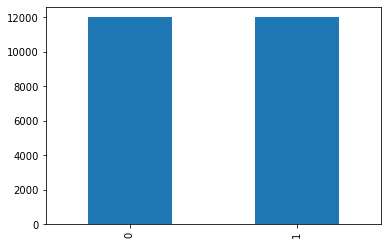

In [13]:
aed_bal = df_aedes['sex'].value_counts()[1] / df_aedes['sex'].count()
print(f"{aed_bal * 100:.2f}% {(1 - aed_bal) * 100:.2f}% of disbalancing")

df_aedes['sex'].value_counts().plot.bar()


#### Normalizing

In [14]:
aed_X = df_aedes.drop(columns=['sex'])
aed_y = df_aedes['sex']

aed_X = (aed_X - aed_X.mean()) / aed_X.std()

aed_X = aed_X.dropna(axis='columns')

aed_X.head()


,wbf,eh_1,eh_2,eh_3,eh_4,eh_5,eh_6,eh_7,eh_8,eh_9,...,eh_17,eh_18,eh_19,eh_20,eh_21,eh_22,eh_23,eh_24,eh_25,temp_range
0,-1.258397,0.031445,-0.274865,-0.851403,0.029622,-0.728188,-0.459166,-0.783356,-0.692515,0.911737,...,-0.566096,-0.591783,-0.418814,0.541144,0.625341,-0.168950,-0.540460,-0.555843,-0.560870,-1.46382
1,-1.138598,1.075257,0.587064,-0.814618,1.434881,-0.421802,0.232911,-0.212425,-0.726204,-0.333448,...,-0.500622,-0.405586,-0.557171,-0.558837,0.052777,1.201722,0.660982,-0.281726,-0.512656,-1.46382
2,-1.106947,4.796488,3.260534,-0.343830,4.080272,0.816283,0.625459,-0.001431,-0.630817,-0.074906,...,-0.305588,-0.296251,-0.513244,-0.528647,-0.087107,1.521921,1.539131,0.100075,-0.443345,-1.46382
3,-1.074568,0.235259,-0.087226,-0.915718,0.629969,-0.417380,-0.070064,-0.507440,-0.815899,-0.670701,...,-0.423600,-0.558985,-0.612531,-0.639888,-0.511617,0.686623,0.990879,-0.031217,-0.559568,-1.46382
4,-0.745798,-0.703380,-0.740123,-0.340994,-0.794587,0.157864,-0.768035,0.038285,-0.530367,-0.682721,...,-0.572164,-0.315000,-0.579583,-0.549170,-0.585769,-0.569073,-0.542841,-0.075203,0.535109,-1.46382


#### train test split

In [ ]:
# from sklearn.model_selection import train_test_split

# aed_X_train, aed_X_test, aed_y_train, aed_y_test = train_test_split(aed_X, aed_y, test_size=0.33, random_state=42)


### Model Training

#### Decision Tree

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV 5/10; 1/36] START criterion=gini, max_depth=4...............................
[CV 5/10; 1/36] END criterion=gini, max_depth=4;, score=0.969 total time=   0.3s
[CV 6/10; 2/36] START criterion=gini, max_depth=5...............................
[CV 6/10; 2/36] END criterion=gini, max_depth=5;, score=0.967 total time=   0.3s
[CV 8/10; 3/36] START criterion=gini, max_depth=6...............................
[CV 8/10; 3/36] END criterion=gini, max_depth=6;, score=0.988 total time=   0.4s
[CV 10/10; 4/36] START criterion=gini, max_depth=7..............................
[CV 10/10; 4/36] END criterion=gini, max_depth=7;, score=0.991 total time=   0.4s
[CV 2/10; 6/36] START criterion=gini, max_depth=9...............................
[CV 2/10; 6/36] END criterion=gini, max_depth=9;, score=0.981 total time=   0.5s
[CV 3/10; 7/36] START criterion=gini, max_depth=10.............

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


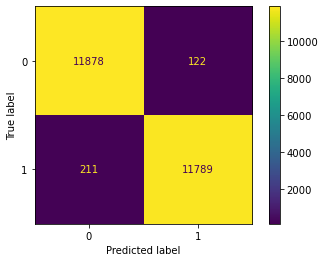

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

aed_dt_params_file = "./params/aed_decision_tree_grided_cv.json"
aed_dt_scores = []

if not exists(aed_dt_params_file):
    # instantiating classifier
    aed_decision_tree_clf = DecisionTreeClassifier(random_state=0)
    # defining testing params
    aed_tree_param = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150]
    }
    # training on each param combination
    aed_decision_tree_grided_cv = GridSearchCV(aed_decision_tree_clf, aed_tree_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    aed_decision_tree_grided_cv.fit(aed_X, aed_y)
    # write file with parameters to save on computation next run
    with open(aed_dt_params_file, "w+") as param_f:
        json.dump(aed_decision_tree_grided_cv.best_params_, param_f, indent=4)

        aed_dt_scores = cross_val_score(aed_decision_tree_grided_cv, aed_X, aed_y, cv=10)
        print(aed_dt_scores)
        plot_confusion_matrix(aed_decision_tree_grided_cv, aed_X, aed_y)
else:
    # read params file
    with open(aed_dt_params_file, "r") as param_f:
        # instantiating classifier
        aed_decision_tree_clf = DecisionTreeClassifier(random_state=0, **json.load(param_f))
        aed_decision_tree_grided_cv = aed_decision_tree_clf.fit(aed_X, aed_y)

        aed_dt_scores = cross_val_score(aed_decision_tree_grided_cv, aed_X, aed_y, cv=10)
        print(aed_dt_scores)
        plot_confusion_matrix(aed_decision_tree_grided_cv, aed_X, aed_y)


#### Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

aed_rf_params_file = "./params/aed_random_forest_grided_cv.json"
aed_rf_scores = []

if not exists(aed_rf_params_file):
    # instantiating classifier
    aed_random_forest_clf = RandomForestClassifier(random_state=0)
    # defining testing params
    aed_tree_param = {
        'bootstrap': [True, False],
        'max_depth': [10, 20, None], # 30, 40, 50, 60, 70, 80, 90, 100, 
        'max_features': ['sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600] #, 800, 1000, 1200, 1400, 1600, 1800, 2000
    }
    # training on each param combination
    aed_random_forest_grided_cv = GridSearchCV(aed_random_forest_clf, aed_tree_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    aed_random_forest_grided_cv.fit(aed_X, aed_y)

    with open("./params/aed_random_forest_grided_cv.json", "w") as param_f:
        json.dump(aed_random_forest_grided_cv.best_params_, param_f, indent=4)

        aed_rf_scores = cross_val_score(aed_random_forest_grided_cv, aed_X, aed_y, cv=10)
        print(aed_rf_scores)
        plot_confusion_matrix(aed_random_forest_grided_cv, aed_X, aed_y)
else:
    with open(aed_rf_params_file, "r") as param_f:
        # instantiating classifier
        aed_random_forest_clf = RandomForestClassifier(random_state=0, **json.load(param_f))
        aed_random_forest_grided_cv = aed_random_forest_clf.fit(aed_X, aed_y)

        aed_rf_scores = cross_val_score(aed_random_forest_grided_cv, aed_X, aed_y, cv=10)
        print(aed_rf_scores)
        plot_confusion_matrix(aed_random_forest_grided_cv, aed_X, aed_y)


Fitting 10 folds for each of 162 candidates, totalling 1620 fits
[CV 2/10; 34/36] START criterion=entropy, max_depth=90..........................
[CV 2/10; 34/36] END criterion=entropy, max_depth=90;, score=0.975 total time=   0.7s
[CV 4/10; 35/36] START criterion=entropy, max_depth=120.........................
[CV 4/10; 35/36] END criterion=entropy, max_depth=120;, score=0.989 total time=   0.6s
[CV 6/10; 36/36] START criterion=entropy, max_depth=150.........................
[CV 6/10; 36/36] END criterion=entropy, max_depth=150;, score=0.955 total time=   0.6s
[CV 8/10; 1/36] START criterion=gini, max_depth=4...............................
[CV 8/10; 1/36] END criterion=gini, max_depth=4;, score=0.989 total time=   0.2s
[CV 9/10; 2/36] START criterion=gini, max_depth=5...............................
[CV 9/10; 2/36] END criterion=gini, max_depth=5;, score=0.988 total time=   0.3s
[CV 1/10; 4/36] START criterion=gini, max_depth=7...............................
[CV 1/10; 4/36] END criteri

#### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

aed_knn_params_file = "./params/aed_knn_grided_cv.json"
aed_knn_scores = []

if not exists(aed_knn_params_file):
    # instantiating classifier
    aed_knn_clf = KNeighborsClassifier()
    # defining testing params
    aed_knn_param = dict(n_neighbors=list(range(1, 31)))
    # training on each param combination
    aed_knn_grided_cv = GridSearchCV(aed_knn_clf, aed_knn_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    aed_knn_grided_cv.fit(aed_X, aed_y)

    with open("./params/aed_knn_grided_cv.json", "w") as param_f:
        json.dump(aed_knn_grided_cv.best_params_, param_f, indent=4)

        aed_knn_scores = cross_val_score(aed_knn_grided_cv, aed_X, aed_y, cv=10)
        print(aed_knn_scores)
        plot_confusion_matrix(aed_knn_grided_cv, aed_X, aed_y)
else:
    with open(aed_knn_params_file, "r") as param_f:
        # instantiating classifier
        aed_knn_clf = KNeighborsClassifier(**json.load(param_f))
        aed_knn_grided_cv = aed_knn_clf.fit(aed_X, aed_y)

        aed_knn_scores = cross_val_score(aed_knn_grided_cv, aed_X, aed_y, cv=10)
        print(aed_knn_scores)
        plot_confusion_matrix(aed_knn_grided_cv, aed_X, aed_y)


### Model Evaluation

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare

stat, p = friedmanchisquare(aed_dt_scores, aed_rf_scores, aed_knn_scores) 

print("p = ", p)

if p < 0.01:
    print("Rejeitamos a hipótese nula")
else:
    print("Aceitamos a hipótese nula")

plt.boxplot([aed_dt_scores, aed_rf_scores, aed_knn_scores], labels=['Decision Tree', 'Random Forest', 'KNN'])
plt.ylim(0.8, 1)
plt.title("AedesSex Models Evaluation Scores")
plt.show()


## Cross Dataset Model Evaluation

In [ ]:
import matplotlib.pyplot as plt

model_scores = []
model_scores.append([arr_dt_scores, arr_rf_scores, arr_knn_scores])
model_scores.append([air_dt_scores, air_rf_scores, air_knn_scores])
model_scores.append([pho_dt_scores, pho_rf_scores, pho_knn_scores])
model_scores.append([phi_dt_scores, phi_rf_scores, phi_knn_scores])
model_scores.append([sat_dt_scores, sat_rf_scores, sat_knn_scores])
model_scores.append([adu_dt_scores, adu_rf_scores, adu_knn_scores])
model_scores.append([aed_dt_scores, aed_rf_scores, aed_knn_scores])

dataset_names = ['Arrythymia', 'Airlines', 'Phoneme', 'Phishing', 'Satellite', 'Adult', 'AedesSex']
model_names = ['Decision Tree', 'Random Forest', 'KNN']
labels = []

for dataset_name in dataset_names:
    for model_name in model_names:
        labels.append(f"{model_name} - {dataset_name}")


plt.boxplot(model_scores, labels=labels)
plt.ylim(0.8, 1)
plt.title("All Models Evaluation Scores")
plt.show()
